In [1]:
import numpy as np
from assimulo.solvers import IDA

In [2]:
class Terminal(object):
    def __init__(self, elem, pin):
        self.elem = elem
        self.pin = pin
    def assign(self, tid):
        self.tid = tid
    def __repr__(self):
        return 'Pin ' + str(self.pin) + ' of ' + repr(self.elem)
    def element(self):
        return self.elem

In [3]:
class State(object):
    def __init__(self, elem, name, value):
        self.elem = elem
        self.name = name
        self.Q = value
    def __repr__(self):
        return 'State variable (' + self.name + ') of ' + repr(self.elem)
    def element(self):
        return self.elem

In [4]:
class Element(object):
    def __init__(self, name, terminal_cnt, **init_state):
        self.name = name
        self.terminals = [Terminal(self, i) for i in range(terminal_cnt)]
        self.states = [State(self, name, val) for name,val in init_state.items()]
    def __getitem__(self, num):
        return self.terminals[num]
    def state(self, num):
        return self.states[num]

In [5]:
class Emf(Element):
    def __init__(self, name=None, E=5, r=0):
        self.r = r
        self.E = E
        super(Emf, self).__init__(name, 2)
    def __repr__(self):
        title = 'EMF ' + self.name if self.name else 'Unnamed EMF'
        return title + ' with r=%g Ohm, E=%g V' % (self.r, self.E)
    def law(self, t):
        E = self.E
        eq1 = self[1].V - self[0].V - E + self[0].I * self.r
        eq2 = self[0].I + self[1].I
        return np.array([eq1, eq2])

In [6]:
class Resistor(Element):
    def __init__(self, name=None, R=100):
        self.R = R
        super(Resistor, self).__init__(name, 2)
    def __repr__(self):
        title = 'Resistor ' + self.name if self.name else 'Unnamed resistor'
        return title + ' with R=%g Ohm' % (self.R)
    def law(self, t):
        eq1 = self[1].V - self[0].V + self[0].I * self.R
        eq2 = self[0].I + self[1].I
        return np.array([eq1, eq2])

In [7]:
class Capacitor(Element):
    def __init__(self, name=None, C=1e-5, U0=0):
        self.C = C
        super(Capacitor, self).__init__(name, 2, Voltage=U0)
        self.Voltage = self.state(0)
    def __repr__(self):
        title = 'Capacitor ' + self.name if self.name else 'Unnamed capacitor'
        return title + ' with C=%g F' % (self.C)        
    def law(self, t):
        eq1 = self[0].I + self.C * self.Voltage.dQdt
        eq2 = self[0].I + self[1].I
        eq3 = self[1].V - self[0].V - self.Voltage.Q
        return np.array([eq1, eq2, eq3])

In [8]:
class Inductor(Element):
    def __init__(self, name=None, L=1e-3, I0=0):
        self.L = L
        super(Inductor, self).__init__(name, 2, Current=I0)
        self.Current = self.state(0)
    def __repr__(self):
        title = 'Inductor ' + self.name if self.name else 'Unnamed inductor'
        return title + ' with L=%g H' % (self.L)        
    def law(self, t):
        eq1 = self[1].V - self[0].V + self.L * self.Current.dQdt
        eq2 = self[0].I + self[1].I
        eq3 = self[0].I - self.Current.Q
        return np.array([eq1, eq2, eq3])

In [9]:
class Ground(Element):
    def __init__(self, name=None):
        super(Ground, self).__init__(name, 1)
    def __repr__(self):
        title = 'Ground ' + self.name if self.name else 'Unnamed ground'
        return title        
    def law(self, t):
        eq1 = self[0].V
        return np.array([eq1])
    
class NotConnected(Element):
    def __init__(self, name=None):
        super(NotConnected, self).__init__(name, 1)
    def __repr__(self):
        title = 'Not connected terminal ' + self.name if self.name else 'Unnamed NC terminal'
        return title           
    def law(self, t):
        eq1 = self[0].I
        return np.array([eq1])

In [10]:
from scipy.sparse import csr_matrix, csgraph
from assimulo.problem import Implicit_Problem

class Circuit(Implicit_Problem):
    def __init__(self, name=None):
        self.connections = set()
        self.terminals = set()
        self.connected_terminals = set()
        self.elements = set()
        self.states = []
        self.name = name if name else repr(self)
        
    def add_element(self, elem):
        if elem in self.elements:
            return
        self.elements.add(elem)
        self.terminals |= set(elem.terminals)
        self.states += elem.states
        
    def connect(self, *args):
        for term in args:
            self.add_element(term.element())
            self.connected_terminals.add(term)
        for i in range(1, len(args)):
            self.connections.add((args[i-1], args[i]))
            
    def process_not_connected(self):
        """
        Присоединить к каждому неподсоединенному выводу экземпляр NotConnected
        """
        terminals_to_connect = self.terminals - self.connected_terminals
        for i,term in enumerate(terminals_to_connect):
            nc = NotConnected('NC[auto]' + str(i))
            self.connect(term, nc[0])    
        assert self.connected_terminals == self.terminals
        
    def enumerate_terminals(self):
        ordered_terminals = []
        for i,term in enumerate(self.terminals):
            term.assign(i)
            ordered_terminals.append(term) 
        self.ordered_terminals = ordered_terminals
    
    def build_connection_graph(self):
        edges = np.empty((2, len(self.connections)), dtype=np.int)
        for i,(t1,t2) in enumerate(self.connections):
            edges[:, i] = t1.tid, t2.tid
        vals = np.ones(edges.shape[1])
        nterm = len(self.terminals)
        return csr_matrix((vals, edges), shape=(nterm, nterm))   
    
    def generate_nodes(self):
        """
        Из списка соединений [(t1, t2), (t1, t5), (t2, t3), (t4, t6), ...]
        выделить связные компоненты - узлы
        
        узел  присоединенные выводы
        0     set(t1, t2, t3, t5)
        1     set(t4, t6)
        ...
        """
        self.process_not_connected()
        # Нумеруем все выводы
        self.enumerate_terminals()
        # Составляем CSR граф соединений выводов
        graph = self.build_connection_graph()
        # И ищем в нем компоненты связности - узлы схемы
        nodes_num, labels = csgraph.connected_components(graph, directed=False)
        nodes = [set() for _ in range(nodes_num)]
        for i,label in enumerate(labels):
            nodes[label].add(self.ordered_terminals[i])
        self.nodes = nodes
    
    def assemble(self, verbose=True):
        self.generate_nodes()
        if verbose:
            print('Nodes:', len(self.nodes))
            print('Terminals:', len(self.terminals))
            print('States:', len(self.states))
            for i, node in enumerate(self.nodes):
                print('Var ', i, ': Node', i, 'voltage')
                for t in node:
                    print('\t', t)
            for i,term in enumerate(self.terminals):
                print('Var ', i+len(self.nodes), ':', term, 'current')
            for i,state in enumerate(self.states):
                print('Var ', i+len(self.nodes)+len(self.terminals), ':', state)
        nvars = len(self.nodes) + len(self.terminals) + len(self.states)
        
        self.t0 = 0.
        self.y0 = np.zeros(nvars)
        self.yd0 = np.zeros(nvars)
        for i,state in enumerate(self.states):
            self.y0[i+len(self.nodes)+len(self.terminals)] = state.Q
            
        self.algvar = self.get_algebraic_variables()
    
    def res(self, t, y, yd):
        ncnt = len(self.nodes)
        nterm = len(self.terminals)
        
        Vs    = y [:ncnt]
        dVsdt = yd[:ncnt]
        Is    = y [ncnt:(ncnt+nterm)]
        dIsdt = yd[ncnt:(ncnt+nterm)]
        Qs    = y [(ncnt+nterm):]
        dQsdt = yd[(ncnt+nterm):]

        r = []
        # Учитываем правила Кирхгофа для каждого узла:
        # сумма токов равна 0
        for node in self.nodes:
            Isum = 0
            for term in node:
                Isum += Is[term.tid]
            r.append(Isum)
        
        # Задаем потенциалы и токи на выводах
        for i,node in enumerate(self.nodes):
            for term in node:
                term.V    = Vs[i]
                term.dVdt = dVsdt[i]
                
        for i,term in enumerate(self.terminals):
            term.I    = Is[i]
            term.dIdt = dIsdt[i]
            
        # Задаем переменные состояния
        for i,state in enumerate(self.states):
            state.Q    = Qs[i]
            state.dQdt = dQsdt[i]
            
        # Учитываем уравнения элементов
        for elem in self.elements:
            r += list(elem.law(t))
            
        assert len(r) == len(y)
        return np.array(r)
    
    def get_algebraic_variables(self):
        """
        Алгебраические переменные - потенциалы V и токи I
        Переменные состояния считаем дифференциальными
        для них заданы начальные условия
        """
        r = np.zeros(len(self.y0))
        r[-len(self.states):] = 1.
        return r
    
    def simulate(self, tmax, nout=500, rtol=1e-8, verbose=False):
        if not hasattr(self, 't0'):
            self.assemble(verbose)
        sim = IDA(self)
        flag, _, _ = sim.make_consistent('IDA_YA_YDP_INIT')
        if flag != 0:
            raise ArithmeticError('make_consistent failed with flag = %d' % flag)
        sim.rtol = rtol
        T,Y,Yd = sim.simulate(tmax, nout)
        ncnt  = len(self.nodes)
        nterm = len(self.terminals)
        
        self.T = T
        Vs    = Y [:, :ncnt]
        dVsdt = Yd[:, :ncnt]
        Is    = Y [:, ncnt:(ncnt+nterm)]
        dIsdt = Yd[:, ncnt:(ncnt+nterm)]
        Qs    = Y [:, (ncnt+nterm):]
        dQsdt = Yd[:, (ncnt+nterm):]
        
        for i,node in enumerate(self.nodes):
            for term in node:
                term.V    = Vs[:, i]
                term.dVdt = dVsdt[:, i]
                
        for i,term in enumerate(self.terminals):
            term.I    = Is[:, i]
            term.dIdt = dIsdt[:, i]
            
        # Задаем переменные состояния
        for i,state in enumerate(self.states):
            state.Q    = Qs[:, i]
            state.dQdt = dQsdt[:, i]        

In [11]:
E1 = Emf("E1", 5)
R1 = Resistor("R1", R=1e3)
R2 = Resistor("R2", R=1e4)
C1 = Capacitor("C1", C=1e-3)
GND = Ground("GND")

In [12]:
c = Circuit("Simple1")
c.connect(E1[1], R1[0])
c.connect(E1[0], C1[0])
c.connect(C1[1], R1[1])
c.connect(R2[0], C1[0])
c.connect(R2[1], C1[1])
c.connect(GND[0], E1[1])
c.simulate(5)

Final Run Statistics: Simple1 

 Number of steps                                 : 104
 Number of function evaluations                  : 132
 Number of Jacobian evaluations                  : 20
 Number of function eval. due to Jacobian eval.  : 260
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 132
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-08

Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.017847261973656714 seconds.


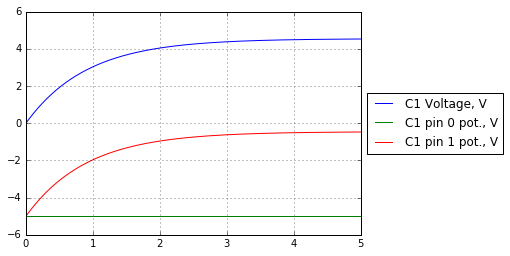

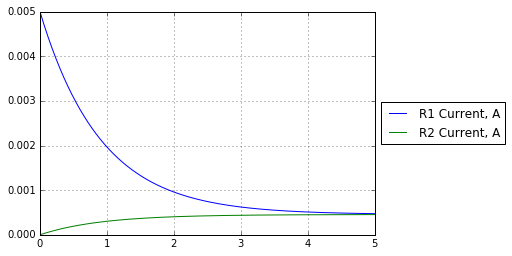

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(c.T, C1.Voltage.Q, label='C1 Voltage, V')
plt.plot(c.T, C1[0].V, label='C1 pin 0 pot., V')
plt.plot(c.T, C1[1].V, label='C1 pin 1 pot., V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c.T, R1[0].I, label='R1 Current, A')
plt.plot(c.T, R2[1].I, label='R2 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.show()

In [17]:
E1 = Emf("E1", 5)
R1 = Resistor("R1", R=1)
L1 = Inductor("L1", L=1)
GND = Ground("GND")

In [18]:
c2 = Circuit("RL")
c2.connect(E1[1], R1[0])
c2.connect(R1[1], L1[1])
c2.connect(E1[0], L1[0])
c2.connect(E1[1], GND[0])
c2.simulate(5)

Final Run Statistics: RL 

 Number of steps                                 : 91
 Number of function evaluations                  : 110
 Number of Jacobian evaluations                  : 18
 Number of function eval. due to Jacobian eval.  : 198
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 110
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-08

Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.012879610992968082 seconds.


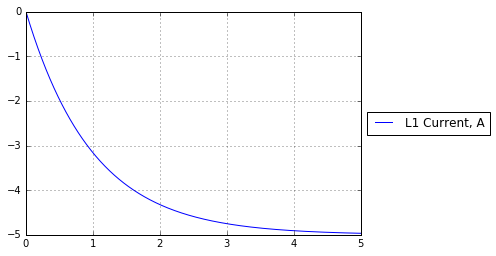

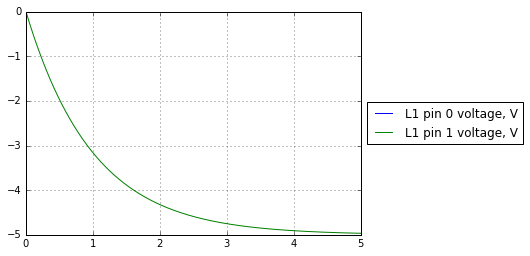

In [22]:
plt.plot(c2.T, L1.Current.Q, label='L1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c2.T, L1[0].V, label='L1 pin 0 voltage, V')
plt.plot(c2.T, L1[1].V, label='L1 pin 1 voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.show()

In [27]:
C1 = Capacitor("C1", C=1, U0=1)
L1 = Inductor("L1", L=1)
GND = Ground("GND")

In [28]:
c3 = Circuit("LC contour")
c3.connect(C1[0], L1[0])
c3.connect(C1[1], L1[1])
c3.connect(C1[1], GND[0])
c3.simulate(20)

Final Run Statistics: LC contour 

 Number of steps                                 : 267
 Number of function evaluations                  : 286
 Number of Jacobian evaluations                  : 15
 Number of function eval. due to Jacobian eval.  : 135
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 286
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-08

Simulation interval    : 0.0 - 20.0 seconds.
Elapsed simulation time: 0.01483274600468576 seconds.


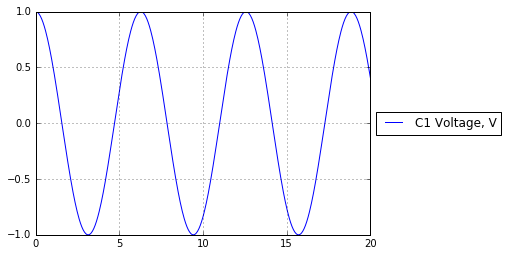

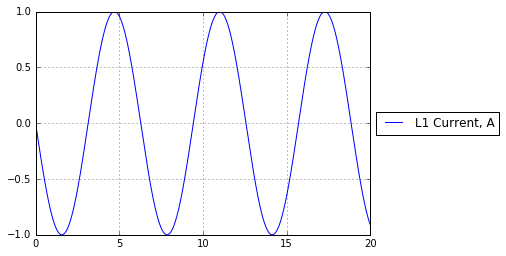

In [31]:
plt.plot(c3.T, C1.Voltage.Q, label='C1 Voltage, V')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()
plt.figure()
plt.plot(c3.T, L1.Current.Q, label='L1 Current, A')
plt.legend(loc='center left', bbox_to_anchor=((1, 0.5)))
plt.grid()